<a href="https://colab.research.google.com/github/nishantgovil03/Research/blob/master/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd


'/content'

In [3]:
%ls 

drive/  sample_data/


In [4]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [5]:
import pandas as pd

In [6]:
data = pd.read_csv("InputData.csv")

In [7]:
data

,Unnamed: 0,Articles without stop words,Article with stop words,Summary
0,0,budget set scene electiongordon brown seek put...,budget to set scene for electiongordon brown w...,<START> increase in the stamp duty threshold f...
1,1,army chiefs regiments decisionmilitary chiefs ...,army chiefs in regiments decisionmilitary chie...,<START> they are very much not for the good an...
2,2,howard denies split id cardsmichael howard den...,howard denies split over id cardsmichael howar...,<START> michael howard has denied his shadow c...
3,3,observers monitor uk electionministers invite ...,observers to monitor uk electionministers will...,<START> the report said individual registratio...
4,4,kilroy names election seat show host robert co...,kilroy names election seat show host robert is...,<START> ukip roger has said he is glad to see ...
...,...,...,...,...
4445,4445,india opens skies competitionindia allow domes...,india opens skies to competitionindia will all...,<START> india will allow domestic commercial a...
4446,4446,yukos bankruptcy us authorities abide us court...,yukos bankruptcy us authorities do not have to...,<START> yukos says a us court was entitled to ...
4447,4447,survey confirms property slowdowngovernment fi...,survey confirms property slowdowngovernment fi...,<START> house prices were higher on the year i...
4448,4448,high fuel prices hit ba profitsbritish airways...,high fuel prices hit ba profitsbritish airways...,<START> rod ba chief said the results were res...


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split

In [9]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


In [10]:
max_art_len=500
max_sum_len=100

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

art_vocab_size=len(article_tokenizer.word_index)+1

In [13]:
art_vocab_size

24225

In [14]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [15]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 500) (1335, 500)


In [16]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)

sum_vocab_size=len(summary_tokenizer.word_index)+1

In [17]:
sum_vocab_size

15775

In [18]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')

In [19]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [20]:
embedding_size = 100
n_units = 300

In [21]:
#model = models.Sequential()
#model.add(layers.Dense(16, activation='relu',input_shape=(max_art_len,)))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dense(16, activation='relu'))

In [22]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,embedding_size,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,embedding_size,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(n_units,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding_layer (Embedd (None, 500, 100)     2422500     input_1[0][0]                    
__________________________________________________________________________________________________
Decoder_Embedding_layer (Embedd (None, None, 100)    1577500     input_2[0][0]                    
______________________________________________________________________________________________

In [23]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [24]:
history = model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=10,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

Epoch 1/10
49/49 [==============================] - 536s 11s/step - loss: 8.4277 - accuracy: 0.0758 - val_loss: 6.6639 - val_accuracy: 0.0914
Epoch 2/10
49/49 [==============================] - 534s 11s/step - loss: 6.6481 - accuracy: 0.0974 - val_loss: 6.5989 - val_accuracy: 0.1207
Epoch 3/10
49/49 [==============================] - 534s 11s/step - loss: 6.5679 - accuracy: 0.1143 - val_loss: 6.5156 - val_accuracy: 0.1258
Epoch 4/10
49/49 [==============================] - 530s 11s/step - loss: 6.4495 - accuracy: 0.1269 - val_loss: 6.2800 - val_accuracy: 0.1514
Epoch 5/10
49/49 [==============================] - 533s 11s/step - loss: 6.2870 - accuracy: 0.1422 - val_loss: 6.1745 - val_accuracy: 0.1607
Epoch 6/10
49/49 [==============================] - 534s 11s/step - loss: 6.1430 - accuracy: 0.1549 - val_loss: 6.1010 - val_accuracy: 0.1661
Epoch 7/10
49/49 [==============================] - 531s 11s/step - loss: 6.0605 - accuracy: 0.1595 - val_loss: 6.0511 - val_accuracy: 0.1695
Epoch 

In [25]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
import matplotlib.pyplot as plt

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
epochs = range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

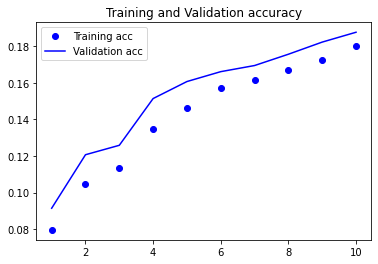

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(epochs , acc , 'bo' ,  label = 'Training acc')
plt.plot(epochs , val_acc , 'b' ,  label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()


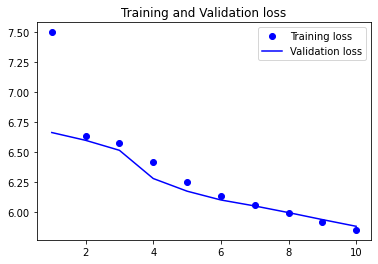

In [31]:
plt.plot(epochs , loss , 'bo' ,  label = 'Training loss')
plt.plot(epochs , val_loss , 'b' ,  label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
